## Assignment: Image recognition
- Alumno : Pablo Ortega

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/4oNHlRFEd71HXp4](https://drive.upm.es/s/4oNHlRFEd71HXp4)

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 4060


In [5]:
!nvidia-smi

Fri Nov  1 12:47:35 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060        Off |   00000000:05:00.0  On |                  N/A |
|  0%   41C    P8             N/A /  115W |     338MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [7]:
categories = {0: 'Cargo plane', 1: 'Helicopter', 2: 'Small car', 3: 'Bus', 4: 'Truck', 5: 'Motorboat', 6: 'Fishing vessel', 7: 'Dump truck', 8: 'Excavator', 9: 'Building', 10: 'Storage tank', 11: 'Shipping container'}

In [8]:
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open('xview_recognition/'+filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

#### Training
Design and train a ffNN to deal with the “xview_recognition” classification task.

In [9]:
import json

# Load database
json_file = 'xview_recognition/xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [10]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'Cargo plane': 635, 'Helicopter': 70, 'Small car': 4290, 'Bus': 2155, 'Truck': 2746, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 4689, 'Storage tank': 1469, 'Shipping container': 1523}


In [11]:
from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True)
print('Number of training images: ' + str(len(anns_train)))
print('Number of validation images: ' + str(len(anns_valid)))

Number of training images: 19239
Number of validation images: 2138


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define model layers
model = nn.Sequential(
    nn.Flatten(),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(224 * 224 * 3, len(categories)),  # Flattened input size with output equal to the number of categories
    nn.Softmax(dim=1)
)

# Print model summary
print(model)


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=150528, out_features=12, bias=True)
  (4): Softmax(dim=1)
)


In [13]:
import torch.optim as optim

# Set the learning rate and other parameters
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-8, amsgrad=True)

# Set up the loss function
criterion = nn.CrossEntropyLoss()  # Categorical cross-entropy equivalent in PyTorch

# Example of gradient clipping
for param in model.parameters():
    param.register_hook(lambda grad: torch.clamp(grad, -1.0, 1.0))  # Clipping gradients at norm 1.0


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [26]:
# Load necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the model architecture
class MyModel(nn.Module):
    def __init__(self, num_classes):
        super(MyModel, self).__init__()
        self.flatten = nn.Flatten()
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(224 * 224 * 3, num_classes)  # Input size is 224x224x3
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Initialize the model
print('Load model')
model = MyModel(num_classes=len(categories)).to(device)  # Move model to GPU
print(model)

# Set up optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)
criterion = nn.CrossEntropyLoss()  # Categorical crossentropy equivalent in PyTorch

# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, objs):
        self.objs = objs
        self.transform = transforms.ToTensor()  # Add any other transforms needed

    def __len__(self):
        return len(self.objs)

    def __getitem__(self, idx):
        filename, obj = self.objs[idx]
        image = load_geoimage(filename)  # Assuming this function returns a PIL Image or ndarray
        label = np.zeros(len(categories))
        label[list(categories.values()).index(obj.category)] = 1
        return self.transform(image), torch.tensor(label, dtype=torch.float32)

# Function to create DataLoaders
def create_data_loader(objs, batch_size, shuffle=False):
    dataset = ImageDataset(objs)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Prepare datasets and loaders
print('Training model')
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]

batch_size = 16
train_loader = create_data_loader(objs_train, batch_size, shuffle=True)
valid_loader = create_data_loader(objs_valid, batch_size, shuffle=False)

# Training loop
epochs = 2
best_val_accuracy = 0
best_epoch = 0

for epoch in range(epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move to GPU
        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(images)
        loss = criterion(outputs, torch.max(labels, 1)[1])  # Use labels' max index for classification
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters

    # Validation
    model.eval()
    val_accuracy = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)  # Move to GPU
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_accuracy += (preds == torch.max(labels, 1)[1]).sum().item()

    val_accuracy /= len(objs_valid)  # Calculate average accuracy
    print(f'Epoch [{epoch + 1}/{epochs}], Validation Accuracy: {val_accuracy:.4f}')

    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch + 1
        torch.save(model, 'model_gpu.pth')  # Save the best model

print(f'Best validation model: epoch {best_epoch} - val_accuracy {best_val_accuracy:.4f}')


Using device: cuda
Load model
MyModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (activation): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=150528, out_features=12, bias=True)
)
Training model
Epoch [1/2], Validation Accuracy: 0.3227
Epoch [2/2], Validation Accuracy: 0.4074
Best validation model: epoch 2 - val_accuracy 0.4074


In [27]:
def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                images.append(load_geoimage(filename))
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

In [28]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
batch_size = 16
train_generator = generator_images(objs_train, batch_size, do_shuffle=True)
valid_generator = generator_images(objs_valid, batch_size, do_shuffle=False)

#### Validation
Compute validation metrics.

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)

In [34]:
device

device(type='cuda')

In [35]:
import torch
import numpy as np
from torchvision import transforms
from PIL import Image

# Assume 'model' is defined as a PyTorch model instance
model = torch.load('model_gpu.pth')  # Load weights (ensure the model structure matches)
model.eval()  # Set the model to evaluation mode

y_true, y_pred = [], []
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    # Add other necessary transformations here (like normalization)
])

for ann in anns_valid:
    # Load image
    image = load_geoimage(ann.filename)  # Assuming this function returns a PIL Image or numpy array
    image_tensor = transform(image)  # Apply transformations
    warped_image = image_tensor.unsqueeze(0).to(device) 

    with torch.no_grad():  # No need to track gradients during inference
        predictions = model(warped_image)  # Forward pass

    # Save prediction
    pred_category = list(categories.values())[torch.argmax(predictions).item()]  # Get predicted category
    pred_score = torch.max(predictions).item()  # Get max prediction score

    # Assuming obj_pred.category is already in the correct format (e.g., string)
    y_true.append(obj_pred.category)
    y_pred.append(pred_category)

# Optionally, you could compute metrics or do further processing with y_true and y_pred


/tmp/ipykernel_7609/43548610.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model_gpu.pth')  # Load weights (ensure the model structure matches)


/tmp/ipykernel_7609/956665539.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))


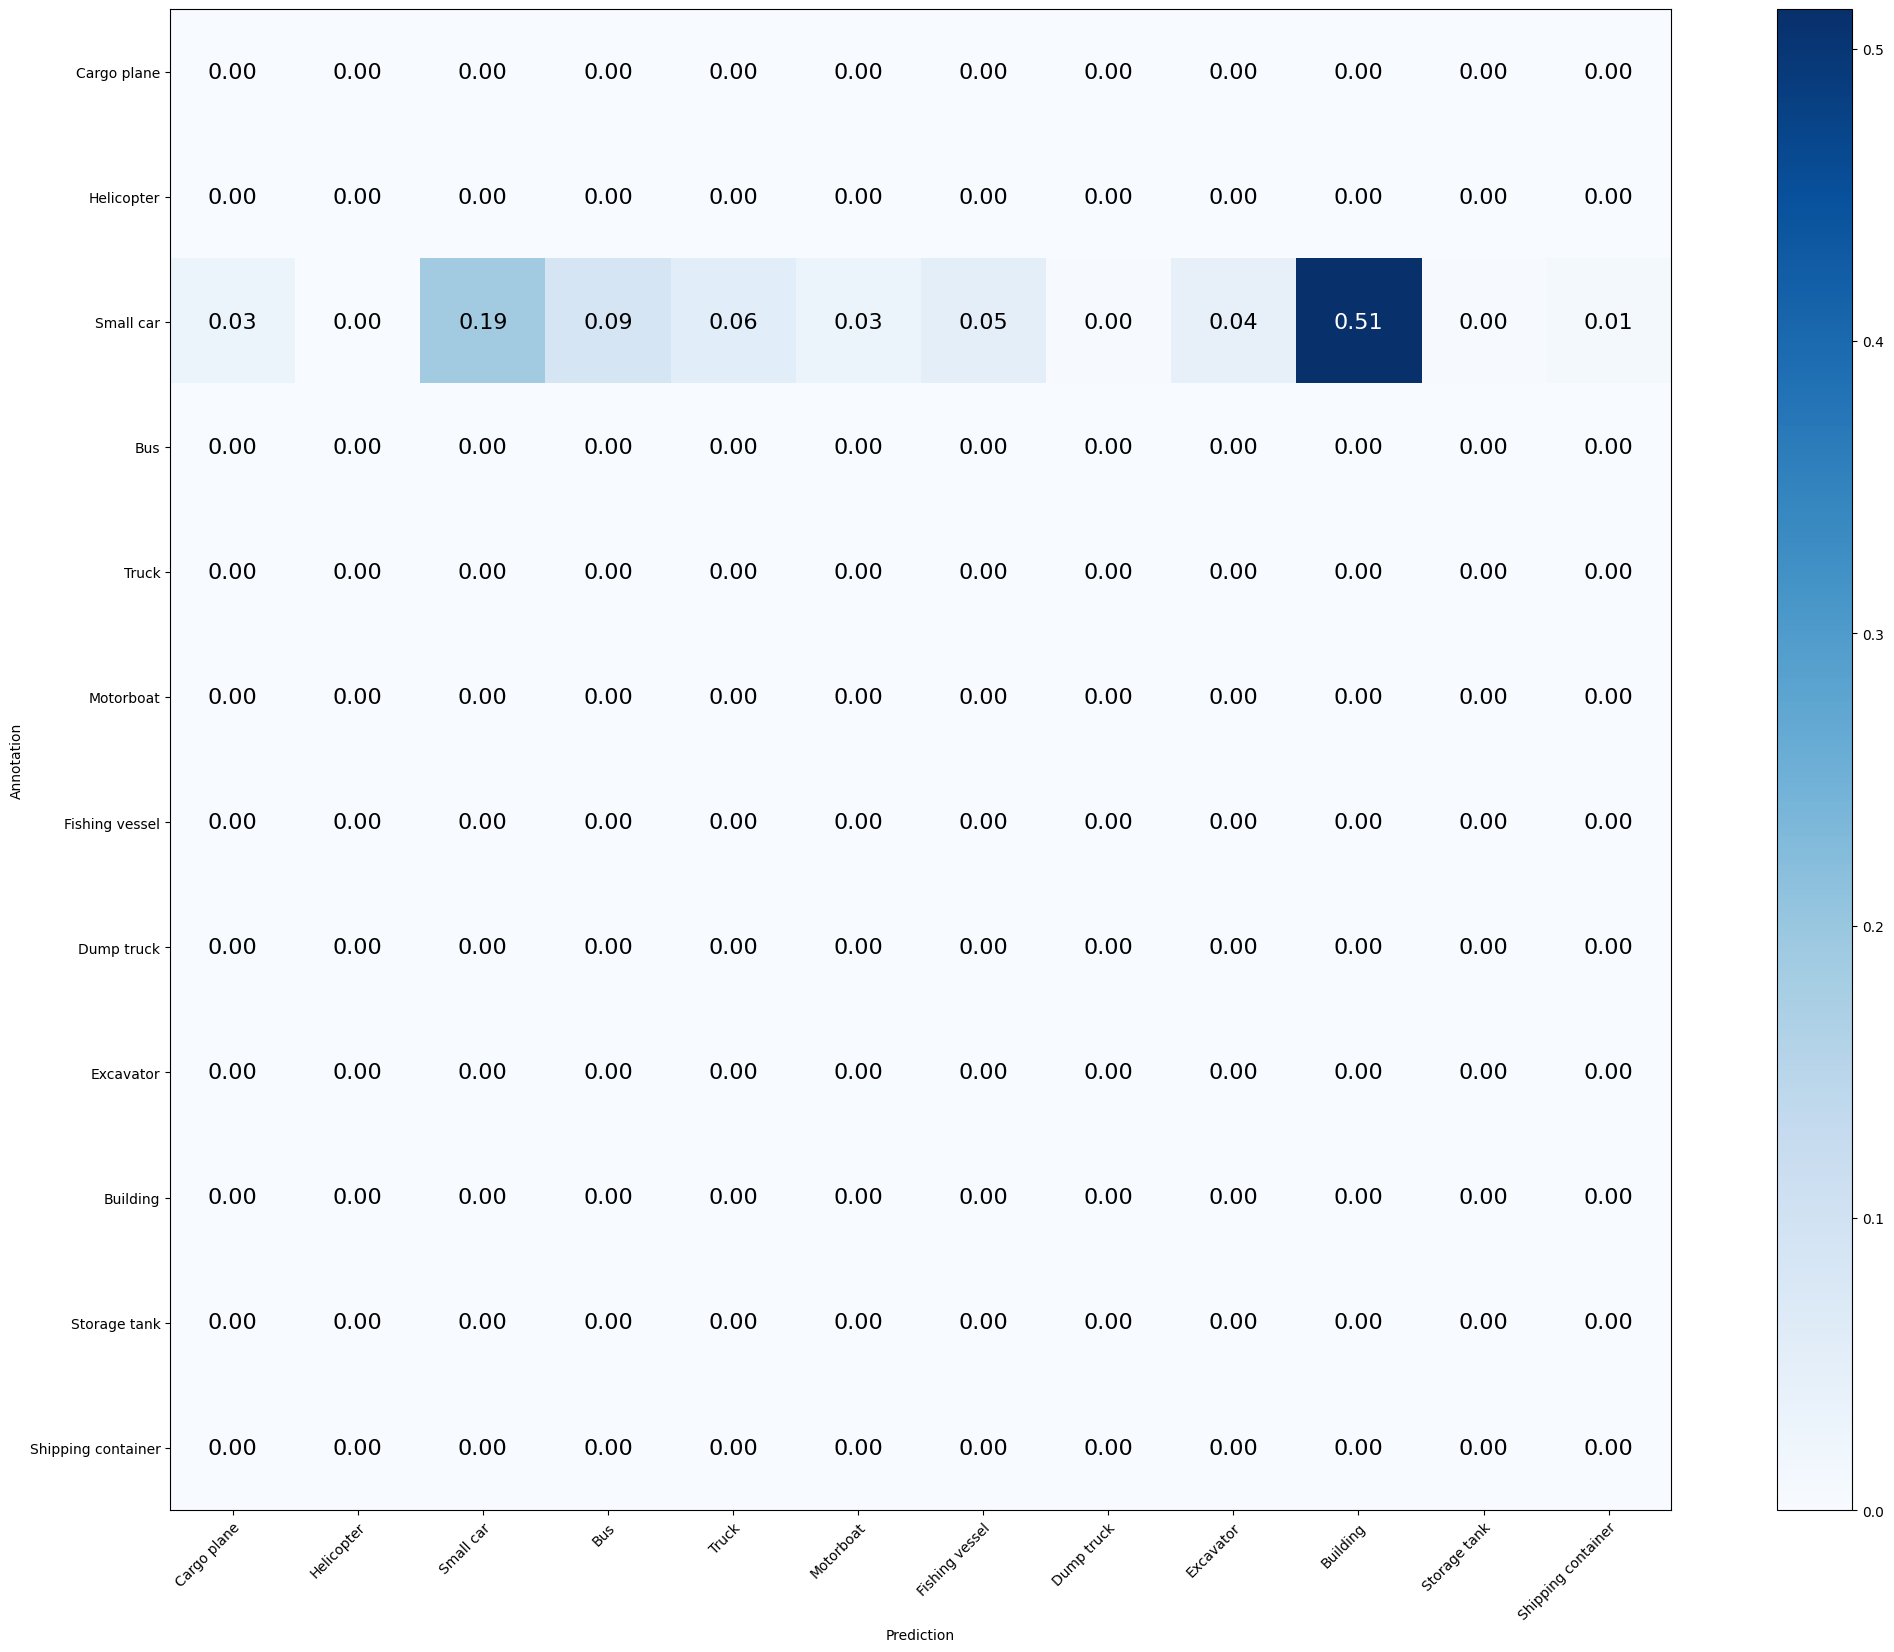

In [36]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [37]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 18.569%
Mean Recall: 1.547%
Mean Precision: 8.333%
> Cargo plane: Recall: 0.000% Precision: 0.000% Specificity: 97.381% Dice: 0.000%
> Helicopter: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Small car: Recall: 18.569% Precision: 100.000% Specificity: 0.000% Dice: 31.321%
> Bus: Recall: 0.000% Precision: 0.000% Specificity: 91.487% Dice: 0.000%
> Truck: Recall: 0.000% Precision: 0.000% Specificity: 94.481% Dice: 0.000%
> Motorboat: Recall: 0.000% Precision: 0.000% Specificity: 97.287% Dice: 0.000%
> Fishing vessel: Recall: 0.000% Precision: 0.000% Specificity: 95.182% Dice: 0.000%
> Dump truck: Recall: 0.000% Precision: 0.000% Specificity: 99.626% Dice: 0.000%
> Excavator: Recall: 0.000% Precision: 0.000% Specificity: 95.978% Dice: 0.000%
> Building: Recall: 0.000% Precision: 0.000% Specificity: 48.644% Dice: 0.000%
> Storage tank: Recall: 0.000% Precision: 0.000% Specificity: 99.626% Dice: 0.000%
> Shipping container: Recall: 0.000% Precision: 0

#### Testing
Try to improve the results provided in the competition.

In [38]:
import os
import numpy as np

anns = []
for (dirpath, dirnames, filenames) in os.walk('xview_recognition/xview_test'):
    for filename in filenames:
        image = GenericImage(dirpath[18:]+'/'+filename)
        image.tile = np.array([0, 0, 224, 224])
        obj = GenericObject()
        obj.bb = (0, 0, 224, 224)
        obj.category = dirpath[dirpath.rfind('/')+1:]
        image.add_object(obj)
        anns.append(image)
print('Number of testing images: ' + str(len(anns)))

Number of testing images: 2635


In [ ]:
model = torch.load('model_gpu.pth') # Load weights
model.eval()  # Set the model to evaluation mode

predictions_data = {"images": {}, "annotations": {}}
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    # Add other necessary transformations here (like normalization)
])

for idx, ann in enumerate(anns):
    # Prepare image data
    image_data = {
        "image_id": ann.filename.split('/')[-1],
        "filename": ann.filename,
        "width": int(ann.tile[2]),
        "height": int(ann.tile[3]),
    }
    predictions_data["images"][idx] = image_data

    # Load image
    image = load_geoimage(ann.filename)  # Assuming this returns a PIL Image
    image_tensor = transform(image)  # Apply transformations
    warped_image = image_tensor.unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():  # No need to track gradients during inference
        predictions = model(warped_image)  # Forward pass

    for obj_pred in ann.objects:
        # Save prediction
        pred_category = list(categories.values())[torch.argmax(predictions).item()]  # Get predicted category
        pred_score = torch.max(predictions).item()  # Get max prediction score
        
        annotation_data = {
            "image_id": ann.filename.split('/')[-1],
            "category_id": pred_category,
            "bbox": [int(x) for x in obj_pred.bb],  # Assuming obj_pred.bb is iterable
        }
        predictions_data["annotations"][idx] = annotation_data



/tmp/ipykernel_7609/2923169034.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model_gpu.pth') # Load weights


In [44]:
with open("prediction.json", "w") as outfile:
    json.dump(predictions_data, outfile)